In [4]:
import yfinance as yf
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import copy
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

C:\Users\aaron\AppData\Local\Temp\ipykernel_4172\1335123836.py:13: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



Get Stock Prices

In [5]:
start_date = "2019-6-20" 
end_date = "2023-6-20"
tickers = ['NVDA', 'META', 'TSLA', 'AMZN', 'GOOG', 'AAPL']
stocks_df = yf.download(tickers, start = start_date, end = end_date)['Adj Close']
stocks_df.head().dropna()

[*********************100%***********************]  6 of 6 completed


,AAPL,AMZN,GOOG,META,NVDA,TSLA
Date,,,,,,
2019-06-20,48.380150,95.909500,55.570999,189.529999,38.315357,14.641333
2019-06-21,48.215210,95.565002,56.094002,191.139999,37.733536,14.790667
2019-06-24,48.166702,95.695000,55.776001,192.600006,37.957310,14.909333
2019-06-25,47.436607,93.913498,54.317501,188.839996,37.663918,14.650667
2019-06-26,48.462620,94.891502,53.990002,187.660004,39.598335,14.618000


In [6]:
stocks_df.tail()

,AAPL,AMZN,GOOG,META,NVDA,TSLA
Date,,,,,,
2023-06-12,183.789993,126.570000,124.349998,271.049988,394.820007,249.830002
2023-06-13,183.309998,126.660004,124.430000,271.320007,410.220001,258.709991
2023-06-14,183.949997,126.419998,124.379997,273.350006,429.970001,256.790009
2023-06-15,186.009995,127.110001,125.790001,281.829987,426.529999,255.899994
2023-06-16,184.919998,125.489998,124.059998,281.000000,426.920013,260.540009


In [7]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import pandas_bokeh
cf.go_offline()
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [8]:
stocks_df.iplot()

In [9]:
fig_price=px.line(stocks_df, title='Price of individual Stocks')
fig_price.show()

We estimate daily returns

In [10]:
daily_returns = stocks_df.pct_change().dropna()
daily_returns.head()

,AAPL,AMZN,GOOG,META,NVDA,TSLA
Date,,,,,,
2019-06-21,-0.003409,-0.003592,0.009411,0.008495,-0.015185,0.010199
2019-06-24,-0.001006,0.001360,-0.005669,0.007638,0.005930,0.008023
2019-06-25,-0.015158,-0.018616,-0.026149,-0.019522,-0.007730,-0.017349
2019-06-26,0.021629,0.010414,-0.006029,-0.006249,0.051360,-0.002230
2019-06-27,-0.000300,0.003399,-0.003510,0.009805,0.024928,0.016281


In [11]:
daily_returns.iplot()

In [12]:
fig=px.line(daily_returns, title='daily_returns')
fig.show()

We estimate daily volatility

In [13]:
daily_returns.std()

AAPL    0.021350
AMZN    0.023094
GOOG    0.020791
META    0.029179
NVDA    0.034125
TSLA    0.042842
dtype: float64

Density plots for daily returns

(-0.1, 0.1)

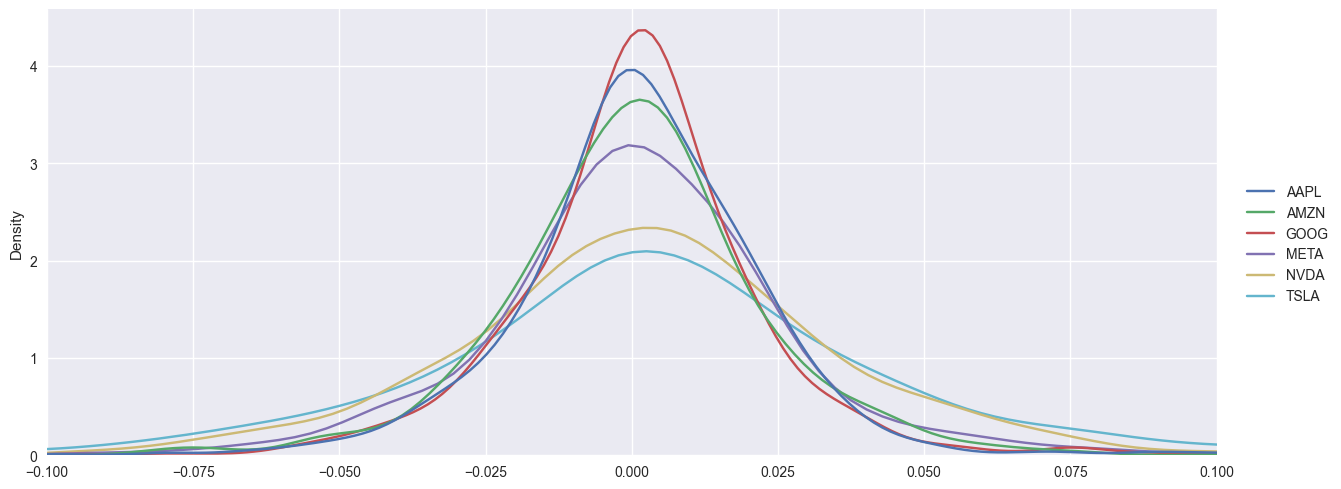

In [14]:
sns.displot(data=daily_returns, kind = 'kde', aspect = 2.5)
plt.xlim(-0.1, 0.1)

We estimate Correlation Matrix

In [15]:
corr_df = stocks_df.corr().round(2) # round to 2 decimal places

In [16]:
corr_df

,AAPL,AMZN,GOOG,META,NVDA,TSLA
AAPL,1.00,0.47,0.86,0.25,0.89,0.90
AMZN,0.47,1.00,0.63,0.82,0.43,0.64
GOOG,0.86,0.63,1.00,0.53,0.85,0.90
META,0.25,0.82,0.53,1.00,0.38,0.38
NVDA,0.89,0.43,0.85,0.38,1.00,0.78
TSLA,0.90,0.64,0.90,0.38,0.78,1.00


In [17]:
corr_df=stocks_df.corr().round(4)
fig_corr=px.imshow(corr_df, text_auto=True, title='Correlation Matrix')
fig_corr.show()

We estimate Expected Returns and Covariance Matrix

In [18]:
mu = expected_returns.mean_historical_return(stocks_df)
S = risk_models.sample_cov(stocks_df)
print(mu)

AAPL    0.399632
AMZN    0.069730
GOOG    0.223084
META    0.103786
NVDA    0.830310
TSLA    1.058290
dtype: float64


1. We estimate Portfolio Returns, Risk Free Rate, Volatility and the Sharpe Ratio
2. Visualize the Efficient Frontier and max Sharpe Ratio Portfolio

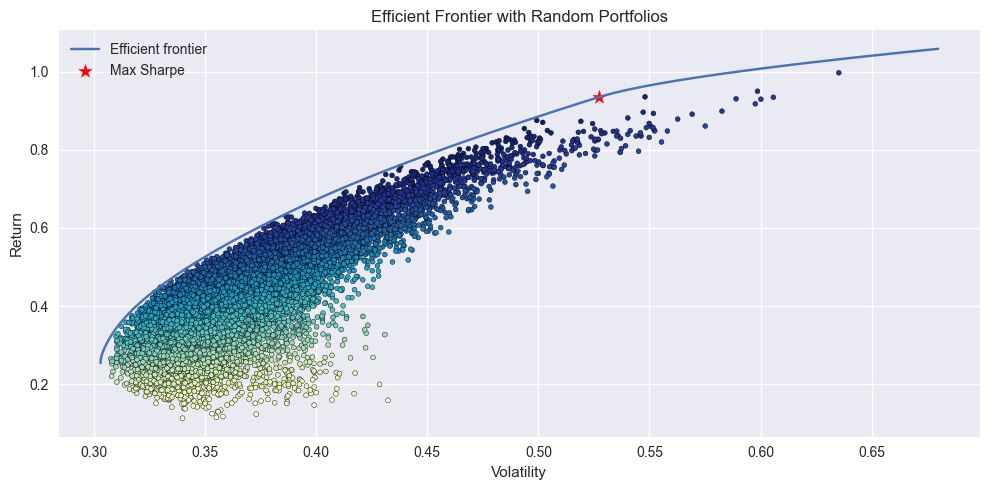

In [19]:
def plot_efficient_frontier_and_max_sharpe(mu, S):  
    # Optimize portfolio for maximal Sharpe ratio 
    ef = EfficientFrontier(mu, S)
    fig, ax = plt.subplots(figsize=(10,5))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)
    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=0.02)
    ret_tangent, std_tangent, _ =   ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r",     label="Max Sharpe")
# Generate random portfolios
    n_samples = 10000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, edgecolors="black", cmap="YlGnBu")
# Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
plot_efficient_frontier_and_max_sharpe(mu, S)

We get weights for optimized portfolio

In [20]:
ef = EfficientFrontier(mu, S)
ef.max_sharpe(risk_free_rate=0.02)
weights = ef.clean_weights()
print(weights)

OrderedDict([('AAPL', 0.0), ('AMZN', 0.0), ('GOOG', 0.0), ('META', 0.0), ('NVDA', 0.5407), ('TSLA', 0.4593)])


In [21]:
weights_df = pd.DataFrame.from_dict(weights, orient = 'index')
weights_df.columns = ['weights']
weights_df

,weights
AAPL,0.0000
AMZN,0.0000
GOOG,0.0000
META,0.0000
NVDA,0.5407
TSLA,0.4593


Expected Annual Return, Annual Volatility and Sharpe Ratio for Optimized Portfolio

In [22]:
expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()
print('Expected annual return: {}%'.format((expected_annual_return*100).round(2)))
print('Annual volatility: {}%'.format((annual_volatility*100).round(2)))
print('Sharpe ratio: {}'.format(sharpe_ratio.round(2)))

Expected annual return: 93.5%
Annual volatility: 52.74%
Sharpe ratio: 1.73


Generate Portfolio with Optimized Weights

In [23]:
stocks_df['Optimized Portfolio'] = 0
for ticker, weight in weights.items():
    stocks_df['Optimized Portfolio'] += stocks_df[ticker]*weight
stocks_df.head()

,AAPL,AMZN,GOOG,META,NVDA,TSLA,Optimized Portfolio
Date,,,,,,,
2019-06-20,48.380150,95.909500,55.570999,189.529999,38.315357,14.641333,27.441878
2019-06-21,48.215210,95.565002,56.094002,191.139999,37.733536,14.790667,27.195876
2019-06-24,48.166702,95.695000,55.776001,192.600006,37.957310,14.909333,27.371374
2019-06-25,47.436607,93.913498,54.317501,188.839996,37.663918,14.650667,27.093932
2019-06-26,48.462620,94.891502,53.990002,187.660004,39.598335,14.618000,28.124867


In [24]:
stocks_df.tail()

,AAPL,AMZN,GOOG,META,NVDA,TSLA,Optimized Portfolio
Date,,,,,,,
2023-06-12,183.789993,126.570000,124.349998,271.049988,394.820007,249.830002,328.226098
2023-06-13,183.309998,126.660004,124.430000,271.320007,410.220001,258.709991,340.631454
2023-06-14,183.949997,126.419998,124.379997,273.350006,429.970001,256.790009,350.428431
2023-06-15,186.009995,127.110001,125.790001,281.829987,426.529999,255.899994,348.159638
2023-06-16,184.919998,125.489998,124.059998,281.000000,426.920013,260.540009,350.501677


In [25]:
stocks_df.iplot()